In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

In [3]:
# Define the ticker symbol, start date, and end date
ticker_symbol = "^GSPC"
start_date = "2000-01-01"
end_date = "2022-01-01"

# Fetch historical stock price data for S&P 500 using yfinance
sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract the 'Close' prices for prediction
data = sp500_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Choose sequence length (number of time steps to look back)
sequence_length = 10
sequences = create_sequences(data_normalized, sequence_length)

# Split data into features and labels
X = sequences[:, :-1]
y = sequences[:, -1]

[*********************100%%**********************]  1 of 1 completed


35/35 [==============================] - 0s 7ms/step - loss: 3.0658e-05
Test Loss: 3.065811324631795e-05
35/35 [==============================] - 1s 7ms/step


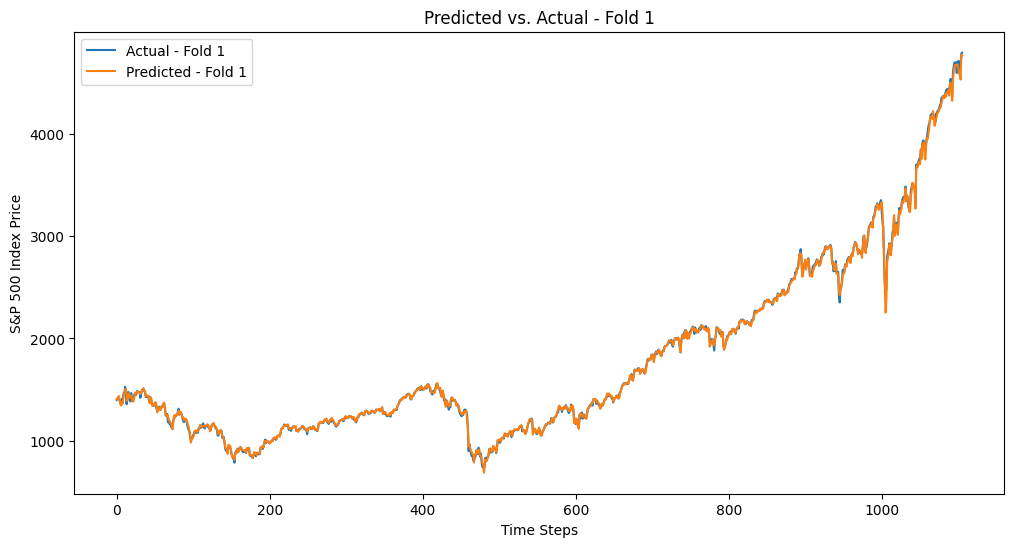

Mean Squared Error (MSE): 519.5265929840888
Root Mean Squared Error (RMSE): 22.793126002900276
Mean Absolute Error (MAE): 14.92972458465191
35/35 [==============================] - 0s 7ms/step - loss: 3.3607e-05
Test Loss: 3.360734262969345e-05
35/35 [==============================] - 1s 7ms/step


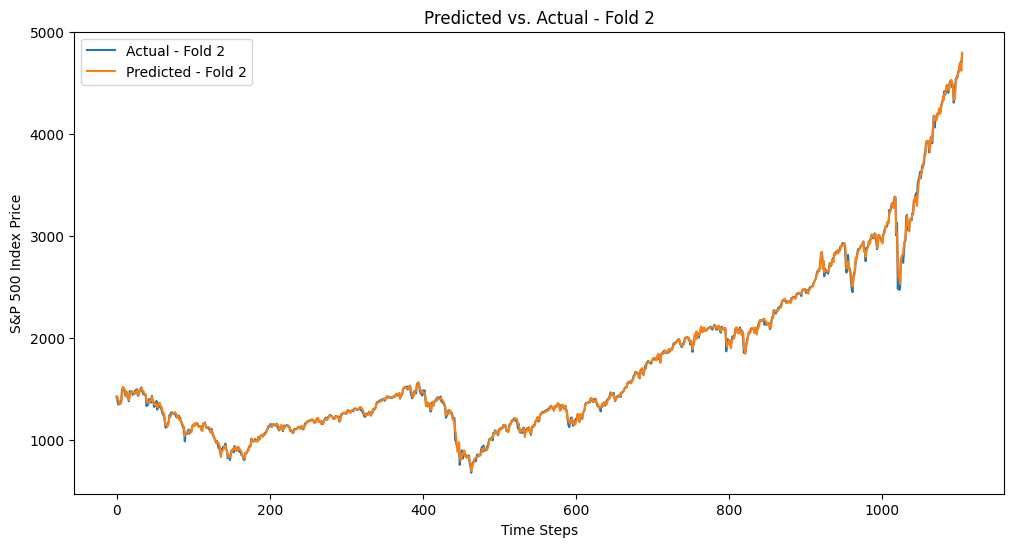

Mean Squared Error (MSE): 569.5039845736727
Root Mean Squared Error (RMSE): 23.864282611754177
Mean Absolute Error (MAE): 15.406969496783098
35/35 [==============================] - 0s 8ms/step - loss: 7.8716e-05
Test Loss: 7.87161334301345e-05
35/35 [==============================] - 1s 7ms/step


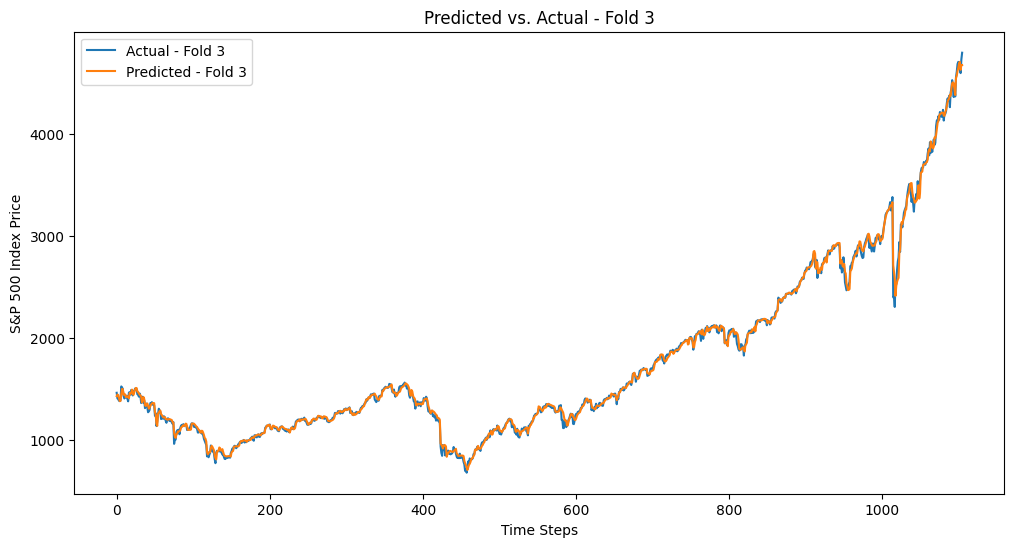

Mean Squared Error (MSE): 1333.909636930815
Root Mean Squared Error (RMSE): 36.5227276764868
Mean Absolute Error (MAE): 24.08373487653776
35/35 [==============================] - 0s 9ms/step - loss: 2.6805e-05
Test Loss: 2.6804687877302058e-05
35/35 [==============================] - 1s 7ms/step


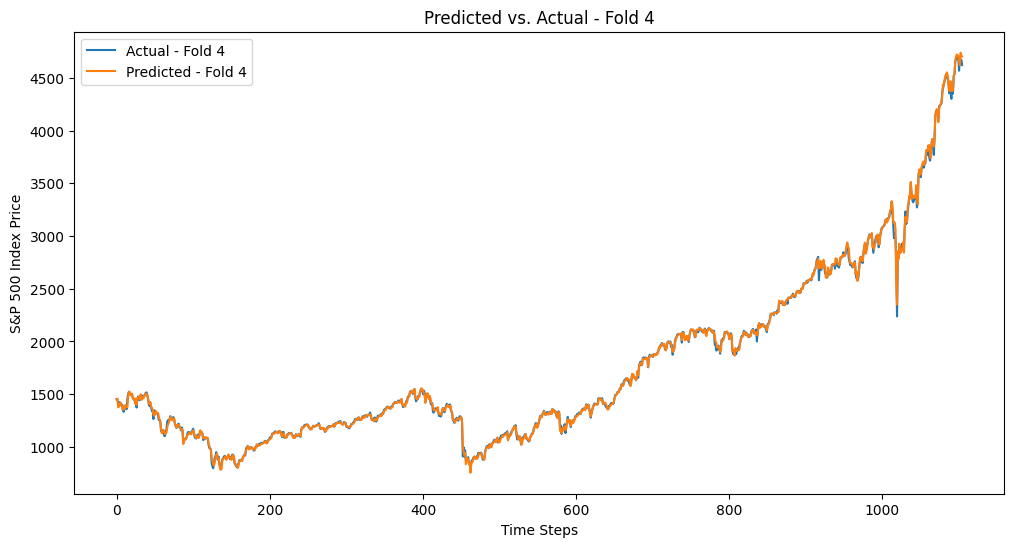

Mean Squared Error (MSE): 454.2274083794205
Root Mean Squared Error (RMSE): 21.31261148661563
Mean Absolute Error (MAE): 13.733505097125986
35/35 [==============================] - 0s 8ms/step - loss: 3.7653e-05
Test Loss: 3.765338260564022e-05
35/35 [==============================] - 1s 7ms/step


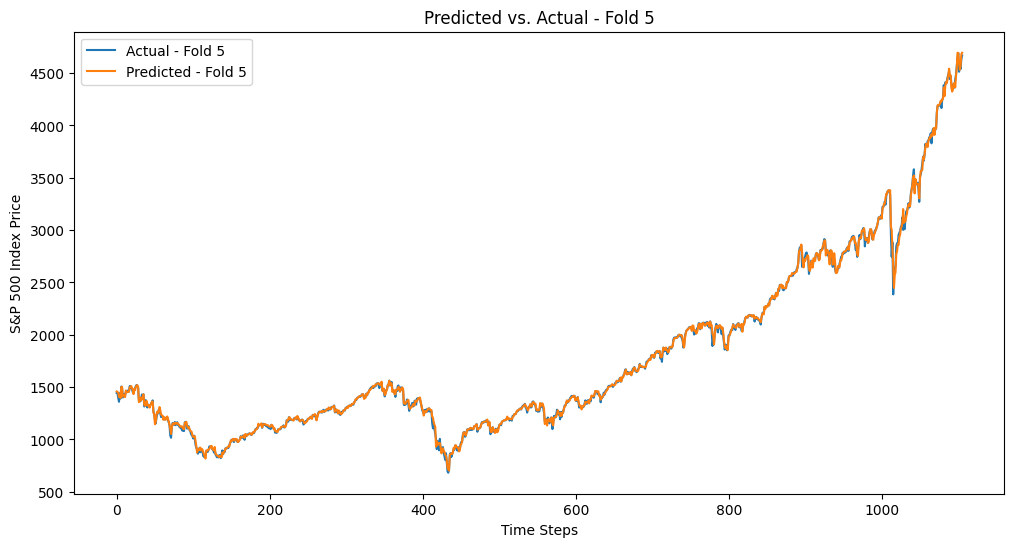

Mean Squared Error (MSE): 638.066538086318
Root Mean Squared Error (RMSE): 25.259978980322174
Mean Absolute Error (MAE): 15.222506782911488
Average Mean Squared Error (MSE) across folds: 703.0468321908629
Average Root Mean Squared Error (RMSE) across folds: 25.950545351615812
Average Mean Absolute Error (MAE) across folds: 16.675288167602048


In [4]:
# Initialize KFold with desired number of splits (k)
n_splits = 5  # Change the number of splits as needed
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
mse_scores, rmse_scores, mae_scores = [], [], []

# Perform k-fold cross-validation
fold_number = 0
for train_index, test_index in kf.split(X):
    fold_number += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build and compile the LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)

    # Make predictions
    predicted_values = model.predict(X_test)

    # Inverse transform the predictions and actual values to original scale
    predicted_values = scaler.inverse_transform(predicted_values)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Make predictions

    # Visualize predicted vs. actual values for each fold
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_original, label=f'Actual - Fold {fold_number}')
    plt.plot(predicted_values, label=f'Predicted - Fold {fold_number}')
    plt.xlabel('Time Steps')
    plt.ylabel('S&P 500 Index Price')
    plt.legend()
    plt.title(f'Predicted vs. Actual - Fold {fold_number}')
    plt.show()


    # Calculate evaluation metrics for the fold
    mse_fold = mean_squared_error(y_test_original, predicted_values)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_test_original, predicted_values)

    # Print evaluation metrics for the fold
    print("Mean Squared Error (MSE):", mse_fold)
    print("Root Mean Squared Error (RMSE):", rmse_fold)
    print("Mean Absolute Error (MAE):", mae_fold)
    print("="*50)

    # Store evaluation metrics for the fold
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)

# Calculate and print average evaluation metrics across all folds
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_mae = np.mean(mae_scores)

print("Average Mean Squared Error (MSE) across folds:", average_mse)
print("Average Root Mean Squared Error (RMSE) across folds:", average_rmse)
print("Average Mean Absolute Error (MAE) across folds:", average_mae)


In [5]:
'''
Original Model:
Mean Squared Error (MSE): 3201.80831333263
Root Mean Squared Error (RMSE): 56.58452362026767
Mean Absolute Error (MAE): 46.36430483054091

Added 50 LSTM Units for a total of 100:
Mean Squared Error (MSE): 1600.2962861860285
Root Mean Squared Error (RMSE): 40.00370340588517
Mean Absolute Error (MAE): 26.560644222211188

Added Dropout 0.2:
Mean Squared Error (MSE): 2327.575799358953
Root Mean Squared Error (RMSE): 48.24495620641554
Mean Absolute Error (MAE): 32.18568748763839

Removed Dropout and changed learning rate to 0.001
Mean Squared Error (MSE): 1400.7363460330703
Root Mean Squared Error (RMSE): 37.4264124119995
Mean Absolute Error (MAE): 24.055243107552567

Double Epochs and Batch Sizes:
Mean Squared Error (MSE): 2308.3255292215545
Root Mean Squared Error (RMSE): 48.04503646810516
Mean Absolute Error (MAE): 37.71658297602576

Early Stopping:
Mean Squared Error (MSE): 1391.765760813871
Root Mean Squared Error (RMSE): 37.30637694568947
Mean Absolute Error (MAE): 23.976936878390596

K Cross Validation:
Average Mean Squared Error (MSE) across folds: 703.0468321908629
Average Root Mean Squared Error (RMSE) across folds: 25.950545351615812
Average Mean Absolute Error (MAE) across folds: 16.675288167602048
'''

'\nOriginal Model:\nMean Squared Error (MSE): 3201.80831333263\nRoot Mean Squared Error (RMSE): 56.58452362026767\nMean Absolute Error (MAE): 46.36430483054091\n\nAdded 50 LSTM Units for a total of 100:\nMean Squared Error (MSE): 1600.2962861860285\nRoot Mean Squared Error (RMSE): 40.00370340588517\nMean Absolute Error (MAE): 26.560644222211188\n\nAdded Dropout 0.2:\nMean Squared Error (MSE): 2327.575799358953\nRoot Mean Squared Error (RMSE): 48.24495620641554\nMean Absolute Error (MAE): 32.18568748763839\n\nRemoved Dropout and changed learning rate to 0.001\nMean Squared Error (MSE): 1400.7363460330703\nRoot Mean Squared Error (RMSE): 37.4264124119995\nMean Absolute Error (MAE): 24.055243107552567\n\nDouble Epochs and Batch Sizes:\nMean Squared Error (MSE): 2308.3255292215545\nRoot Mean Squared Error (RMSE): 48.04503646810516\nMean Absolute Error (MAE): 37.71658297602576\n\nEarly Stopping:\nMean Squared Error (MSE): 1391.765760813871\nRoot Mean Squared Error (RMSE): 37.30637694568947\